# Time series forecasting

#### Content: jupyter notebook for time series forecasting based on statsmodels library
#### Use: Forecasting time series and theory of the procedures behind the code
#### Author: Gonzalo Espino Gómez 
#### Version: 1.0
#### Creation date: 5 March 2023
#### Theorical background:

##### [1] Hyndman, R.J., & Athanasopoulos, G. (2018) Forecasting: principles and practice, 2nd edition, OTexts: Melbourne, Australia. OTexts.com/fpp2. Accessed on 4 March 2023.
##### --> The book exposes theory for time series forecasting and procedures to implement models by statistical package R

##### [2] B. Artley, Time Series Forecasting with ARIMA , SARIMA and SARIMAX, A deep-dive on the gold standard of time series forecastin https://towardsdatascience.com/time-series-forecasting-with-arima-sarima-and-sarimax-ee61099e78f6
##### --> Shows implementation for ARIMA and SARIMAX models thorugh python statsmodels


##### [3] Hyndman, R.J., & Athanasopoulos, G. (2018) Forecasting: principles and practice,Chapter 3.5. ''Prediction intervals"  2nd edition, OTexts: Melbourne, Australia. OTexts.com/fpp2. Accessed on 4 March 2023.
##### --> The book exposes theory for time series forecasting and procedures to implement models by statistical package R


#####  [4] J. Rodrigo. Prediction intervals https://joaquinamatrodrigo.github.io/skforecast/0.5.0/user_guides/prediction-intervals.html
##### ---> Advanced methods to generate prediction intervals in python





### Libraries:
#### If not working please check versions of the library and update through pip install [...] --upgrade

In [21]:
#Libraries for the computation
import numpy as np
import pandas as pd
import statsmodels as sm
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
import matplotlib.dates as mdates

### Data for the analysis:
#### We will import a csv file (coma separated values), it can be created thorugh excel (save as), atention to language, decimal symbol and column separation notation

In [22]:
#Parse dates converts an integer to pandas date-time format
#Index_colum converts a column to the index; this facilitates analysis, eliminates a variable and is a convention
#when working with time series analysis; thus, it is needed for compatibility.
df=pd.read_csv('Sales_Toray_Dat.csv',sep=';',parse_dates=['Date'],index_col=['Date'])
df.head(5)

,Sales_CF
Date,
2009-06-30,69
2009-09-30,145
2009-12-31,243
2010-03-31,350
2010-06-30,108


### Initial data visual analysis

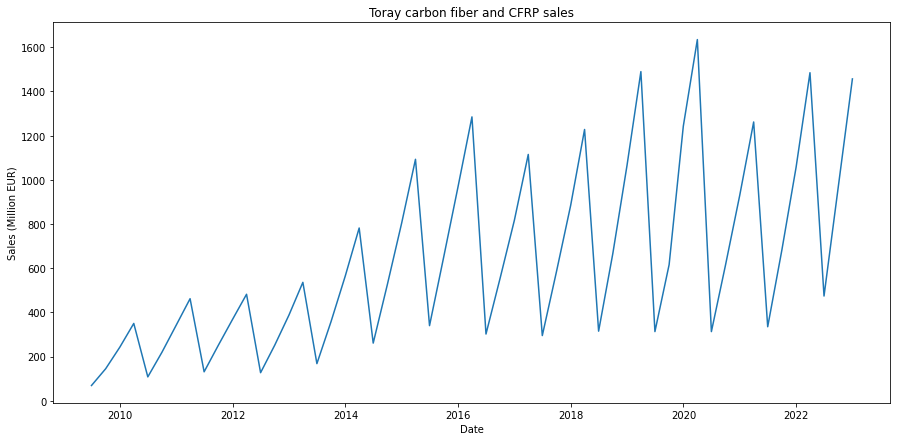

In [23]:
plt.figure(figsize=(15,7))
plt.title("Toray carbon fiber and CFRP sales")
plt.xlabel('Date')
plt.ylabel('Sales (Million EUR)')
plt.plot(df)
plt.show()

### Rolling statistics

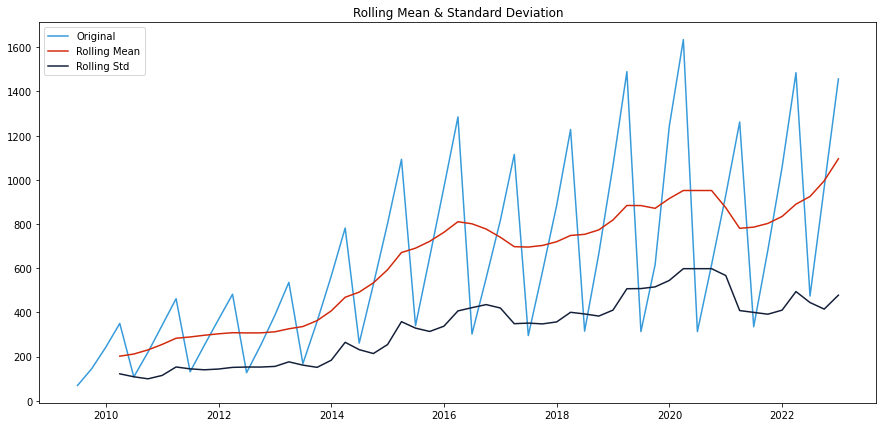

In [24]:
#Determine rolling statistics
df["rolling_avg"] = df['Sales_CF'].rolling(window=4).mean() #window size 4 denotes 4 months, giving rolling mean at yearly level
df["rolling_std"] = df['Sales_CF'].rolling(window=4).std()

#Plot rolling statistics
plt.figure(figsize=(15,7))
plt.plot(df['Sales_CF'], color='#379BDB', label='Original')
plt.plot(df["rolling_avg"], color='#D22A0D', label='Rolling Mean')
plt.plot(df["rolling_std"], color='#142039', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

### Augmented DIckey-Fuller Test

In [25]:
#Augmented Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
dftest = adfuller(df['Sales_CF'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

## If Test Statistic is below p-value, data is not stationary


Results of Dickey Fuller Test:
Test Statistic                 -1.010011
p-value                         0.749596
#Lags Used                     10.000000
Number of Observations Used    44.000000
Critical Value (1%)            -3.588573
Critical Value (5%)            -2.929886
Critical Value (10%)           -2.603185
dtype: float64


## ARIMA and SARIMA models
##### ARIMA, SARIMA, SARIMAX are standard methods for time series forecasting; other models may achieve better prediction for data. 
##### ARIMA; SARIMA and SARIMAX imply multiple parameters that can be tunned to adapt the model, pmdarima will be employed for optimization.
##### For theory, access [2]

### ARIMA Model Selection with Auto-ARIMA

In [26]:
#Standard ARIMA Model
ARIMA_model = pm.auto_arima(df['Sales_CF'], 
                      start_p=1, 
                      start_q=1,
                      test='adf', # use adftest to find optimal 'd'
                      max_p=10, max_q=10, # maximum p and q
                      m=4, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                      d=None,# let model determine 'd'
                      seasonal=False, # No Seasonality for standard ARIMA
                      trace=False, #logs 
                      error_action='warn', #shows errors ('ignore' silences these)
                      suppress_warnings=True,
                      stepwise=True)
ARIMA_model

/Users/gonzaloespinogomez/anaconda3/lib/python3.7/site-packages/pmdarima/arima/_validation.py:62: UserWarning: m (4) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


ARIMA(order=(4, 2, 1), scoring_args={}, suppress_warnings=True)

### ARIMA Model Diagnostics (residuals)
#### · Standardized residuals
#### · Histogram plus KDE estimate
#### · Normal Q-Q
#### · Correlogram (ACF plot)

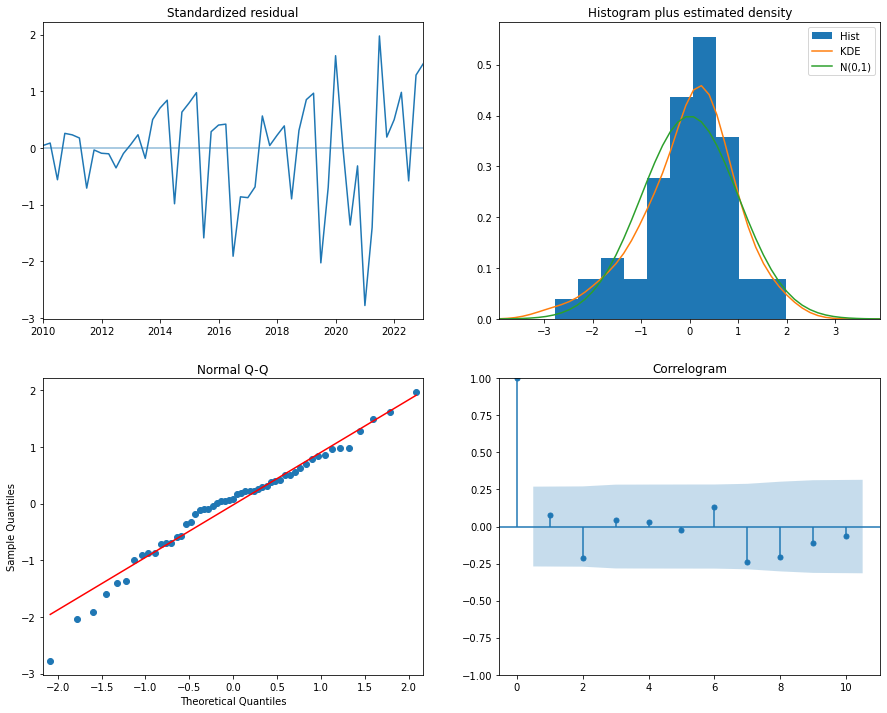

In [27]:
ARIMA_model.plot_diagnostics(figsize=(15,12))
plt.show()

*Attention ACF is applied to residuals, NOT TO TIME SERIES, for residuals it is expected that values are not significant (inside confidence interval) this means that the residuals do not keep information. The lower the ACF the better.

### ARIMA model for 5 year prediction

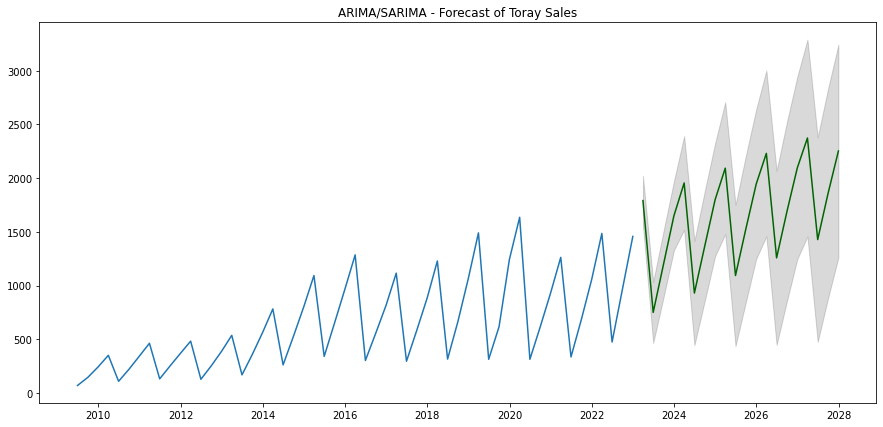

In [28]:
# Forecast
n_periods = 20
fitted, confint = ARIMA_model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods = n_periods, freq='Q')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.figure(figsize=(15,7))
plt.plot(df["Sales_CF"], color='#1f76b4')
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                lower_series, 
                upper_series, 
                color='k', alpha=.15)

plt.title("ARIMA/SARIMA - Forecast of Toray Sales")
plt.show()

This does not seem a very accurate forecast

Text(1, 1.5, 'look at this point')

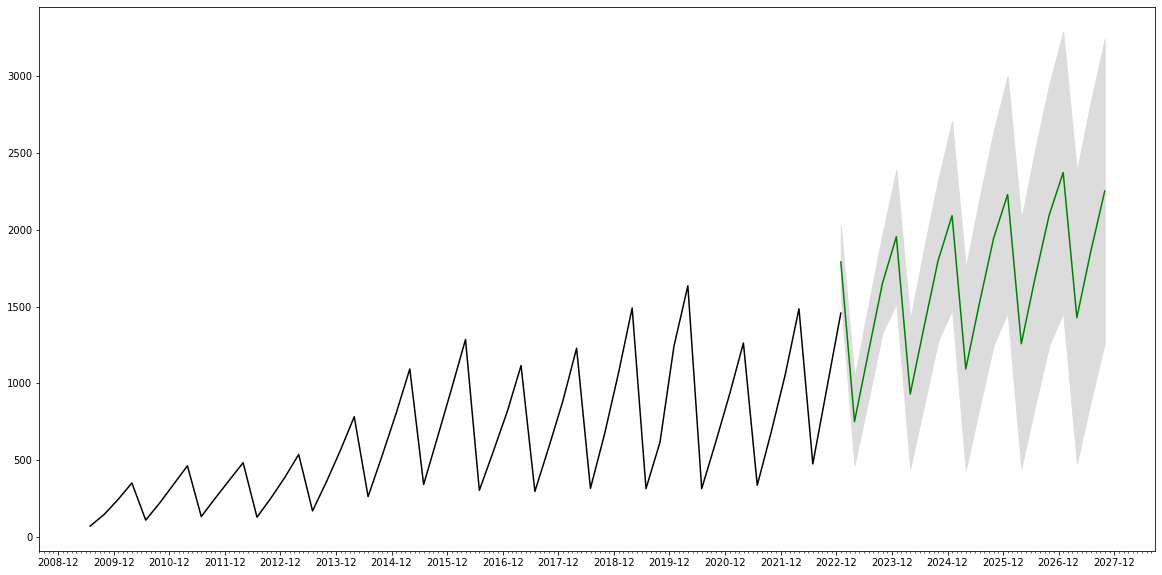

In [29]:
# Forecast
n_periods = 20
fitted, confint = ARIMA_model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods = n_periods, freq='Q')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
fig1=plt.figure()
fig1.set_size_inches(20,10)#Set figure size
ax1=fig1.add_subplot(1,1,1)
ax1.plot(df.index,df['Sales_CF'],color='black')
ax1.plot(pd.date_range('2022-12-31', periods=20, freq='Q'),fitted_series,color='green')
#ax1.plot(pd.date_range('2022-12-31', periods=24, freq='Q'),lower_series,color='blue')
#ax1.plot(pd.date_range('2022-12-31', periods=24, freq='Q'),upper_series,color='red')
ax1.fill_between(pd.date_range('2022-12-31', periods=20, freq='Q'), lower_series, upper_series,color='gainsboro')
ax1.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(12)))
ax1.xaxis.set_minor_locator(mdates.MonthLocator())
ax1.annotate('look at this point',xy=(10,30),
    xytext=(1, 1.5), 
    arrowprops={"facecolor": "black"},
    horizontalalignment="center", verticalalignment="top")


In [32]:
fitted_series

2023-03-31    1790.472956
2023-06-30     749.781021
2023-09-30    1198.968575
2023-12-31    1648.944423
2024-03-31    1954.743685
2024-06-30     929.614015
2024-09-30    1367.636472
2024-12-31    1798.936319
2025-03-31    2092.564526
2025-06-30    1092.796430
2025-09-30    1526.800407
2025-12-31    1944.828514
2026-03-31    2230.076798
2026-06-30    1257.401812
2026-09-30    1688.955617
2026-12-31    2095.246802
2027-03-31    2373.228473
2027-06-30    1427.551367
2027-09-30    1856.957015
2027-12-31    2252.156378
Freq: Q-DEC, dtype: float64

In [31]:
print('last forecast is dated: 2028-12-31')
print('forecast value=',fitted_series.iloc[-1])
print('upper limit=',upper_series.iloc[-1])
print('lower limit=',lower_series.iloc[-1])

last forecast is dated: 2028-12-31
forecast value= 2252.156377815829
upper limit= 3243.015703364588
lower limit= 1261.2970522670698


In [37]:
index_of_fc

DatetimeIndex(['2023-03-31', '2023-06-30', '2023-09-30', '2023-12-31',
               '2024-03-31', '2024-06-30', '2024-09-30', '2024-12-31',
               '2025-03-31', '2025-06-30', '2025-09-30', '2025-12-31',
               '2026-03-31', '2026-06-30', '2026-09-30', '2026-12-31',
               '2027-03-31', '2027-06-30', '2027-09-30', '2027-12-31',
               '2028-03-31', '2028-06-30', '2028-09-30', '2028-12-31'],
              dtype='datetime64[ns]', freq='Q-DEC')

In [42]:
fitted_series

2023-03-31    1790.472956
2023-06-30     749.781021
2023-09-30    1198.968575
2023-12-31    1648.944423
2024-03-31    1954.743685
2024-06-30     929.614015
2024-09-30    1367.636472
2024-12-31    1798.936319
2025-03-31    2092.564526
2025-06-30    1092.796430
2025-09-30    1526.800407
2025-12-31    1944.828514
2026-03-31    2230.076798
2026-06-30    1257.401812
2026-09-30    1688.955617
2026-12-31    2095.246802
2027-03-31    2373.228473
2027-06-30    1427.551367
2027-09-30    1856.957015
2027-12-31    2252.156378
2028-03-31    2523.365915
2028-06-30    1604.186688
2028-09-30    2031.462358
2028-12-31    2416.004521
Freq: Q-DEC, dtype: float64

### SARIMA model
Sarima model will account for seasonality

In [ ]:
# Seasonal - fit stepwise auto-ARIMA
SARIMA_model = pm.auto_arima(df['Sales_CF'], start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, 
                         m=4, #4 is the frequncy of the cycle
                         start_P=0, 
                         seasonal=True, #set to seasonal
                         d=None, 
                         D=1, #order of the seasonal differencing
                         trace=False,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

### SARIMA Model Diagnostics (residuals)
#### · Standardized residuals
#### · Histogram plus KDE estimate
#### · Normal Q-Q
#### · Correlogram (ACF plot)

In [ ]:
SARIMA_model.plot_diagnostics(figsize=(15,12))
plt.show()

*Attention ACF is applied to residuals, NOT TO TIME SERIES, for residuals it is expected that values are not significant (inside confidence interval) this means that the residuals do not keep information. The lower the ACF the better.

In [ ]:
Forecast(SARIMA_model)

Prediction interval is out of scope because of complexity, see rockwell, P. J., & Davis, R. A. (2016). Introduction to time series and forecasting (3rd ed). New York, USA: Springer. 